In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import sentiment
import joblib
lr=joblib.load('lr.pkl')
vect=joblib.load('vector.pkl')
import df

In [118]:
class CorrelationAnalysis:
    def __init__(self, df_combined):
        """
        Initialize correlation analysis.
        
        df_combined: DataFrame with dates, prices, and sentiments
        """
        self.df = df_combined.copy()
        self._calculate_returns()
    
    def _calculate_returns(self):
        """Calculate daily and next-day returns."""
        self.df['daily_return'] = self.df['Close'].pct_change()/10
        self.df['next_day_return'] = self.df['daily_return'].shift(-1)
    
    def calculate_correlations(self):
        """
        Calculate correlation between each sentiment method
        and next-day returns.
        
        Returns: DataFrame with correlations and p-values
        """
        correlations = []
        
        for method in ['vader_sentiment', 'lr_sentiment', 'finbert_sentiment']:
            # Remove NaN values
            valid_idx = ~(self.df[method].isna() | self.df['next_day_return'].isna())
            x = self.df[valid_idx][method]
            y = self.df[valid_idx]['next_day_return']
            
            # Calculate Pearson correlation
            r, p_value = stats.pearsonr(x, y)
            
            correlations.append({
                'method': method.replace('_sentiment', '').upper(),
                'correlation': r,
                'p_value': p_value,
                'n_samples': valid_idx.sum()
            })
        
        df_corr = pd.DataFrame(correlations)
        return df_corr
    def my_correlations(self):
        """
        Calculate correlation between each sentiment method
        focussing only on market up or down, no measure of 'how much'
        
        Returns: DataFrame with correlations and p-values
        """
        correlations = []
        threshold=0.02
        def signal_from_sentiment(sentiment):
            if pd.isna(sentiment):
                return 0
            elif sentiment > threshold:
                return 1  # Buy
            elif sentiment < -threshold:
                return -1  # Sell
            else:
                return 0  # Hold
        x=dict()
        y=dict()
        date=[]
        for method in ['vader_sentiment', 'lr_sentiment', 'finbert_sentiment']:
            # Remove NaN values
            valid_idx = ~(self.df[method].isna() | self.df['next_day_return'].isna())
            date=self.df[valid_idx]['date']
            x[method] = self.df[valid_idx][method].apply(signal_from_sentiment)
            y[method] = (self.df[valid_idx]['next_day_return']*10).apply(signal_from_sentiment)
            
            # Calculate Pearson correlation
            r, p_value = stats.pearsonr(x[method], y[method])
            
            correlations.append({
                'method': method.replace('_sentiment', '').upper(),
                'correlation': r,
                'p_value': p_value,
                'n_samples': valid_idx.sum()
            })
        
        df_corr = pd.DataFrame(correlations)
        return (df_corr,x,y,date)
    
    def generate_trading_signals(self, threshold=0.3):
        """
        Generate buy/sell/hold signals based on sentiment.
        
        Parameters:
        - threshold: Sentiment threshold for signals
        
        Returns: DataFrame with signals
        """
        def signal_from_sentiment(sentiment):
            if pd.isna(sentiment):
                return 0
            elif sentiment > threshold:
                return 1  # Buy
            elif sentiment < -threshold:
                return -1  # Sell
            else:
                return 0  # Hold
        
        self.df['signal_vader'] = self.df['vader_sentiment'].apply(signal_from_sentiment)
        self.df['signal_lr'] = self.df['lr_sentiment'].apply(signal_from_sentiment)
        self.df['signal_finbert'] = self.df['finbert_sentiment'].apply(signal_from_sentiment)
        
        return self.df[['date', 'signal_vader', 'signal_lr', 'signal_finbert']]
    
    def visualize_sentiment_vs_price(self,compare='Next-day Return (%)'):
        """
        Create time series plot showing sentiment and price movement.
        """
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        
        # Plot 1: VADER sentiment vs returns
        axes[0].plot(self.df['date'], self.df['vader_sentiment'], label='VADER Sentiment', color='blue', alpha=0.7)
        axes[0].scatter(self.df['date'], self.df['next_day_return'] * 100, label=compare, color='red', alpha=0.3, s=20)
        axes[0].set_title('VADER Sentiment vs Stock Returns')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Logistic Regression sentiment vs returns
        axes[1].plot(self.df['date'], self.df['lr_sentiment'], label='LR Sentiment', color='green', alpha=0.7)
        axes[1].scatter(self.df['date'], self.df['next_day_return'] * 100, label=compare, color='red', alpha=0.3, s=20)
        axes[1].set_title('Logistic Regression Sentiment vs Stock Returns')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: FinBERT sentiment vs returns
        axes[2].plot(self.df['date'], self.df['finbert_sentiment'], label='FinBERT Sentiment', color='purple', alpha=0.7)
        axes[2].scatter(self.df['date'], self.df['next_day_return'] * 100, label=compare, color='red', alpha=0.3, s=20)
        axes[2].set_title('FinBERT Sentiment vs Stock Returns')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    def visualize2(self,x,y,date,compare='up/down'):
        """
        Create time series plot showing sentiment and price movement.
        """
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        #self.df = self.df.dropna(subset=[''])
        # Plot 1: VADER sentiment vs returns
        axes[0].plot(date, x['vader_sentiment'], label='VADER Sentiment', color='blue',alpha=0.7)
        axes[0].plot(date, y['vader_sentiment'], label=compare, color='red',alpha=0.3)
        axes[0].set_title('VADER Sentiment vs Stock Returns')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Logistic Regression sentiment vs returns
        axes[1].plot(date, x['lr_sentiment'], label='LR Sentiment', color='green', alpha=0.7)
        axes[1].plot(date, y['lr_sentiment'], label=compare, color='red', alpha=0.3)
        axes[1].set_title('Logistic Regression Sentiment vs Stock Returns')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: FinBERT sentiment vs returns
        axes[2].plot(date, x['finbert_sentiment'], label='FinBERT Sentiment', color='purple', alpha=0.7)
        axes[2].plot(date, y['finbert_sentiment'], label=compare, color='red', alpha=0.3)
        axes[2].set_title('FinBERT Sentiment vs Stock Returns')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

In [124]:
obj=sentiment.RealDataSentimentAnalyzer(vect,lr)
#obj.load_financial_news('apple_news_data.csv')
obj2=df.RealDataPipeline(start_date='2018-01-01',end_date='2021-12-31')
obj2.download_stock_prices()
obj2.load_financial_news('apple_news_data.csv')
obj2.align_data()
print("The merged dataframe is as follows") 
print(obj2.df_combined.head())
headlines=obj2.df_combined['all_headlines']
obj2.df_combined[['vader_sentiment','lr_sentiment','finbert_sentiment']]=obj.score_all_headlines(headlines)[['vader_sentiment','lr_sentiment','finbert_sentiment']]
data=obj2.df_combined

Downloaded 1007 days of price data
Loading news data from apple_news_data.csv...
Loaded 29752 news articles for AAPL
Combined dataset shape: (399, 7)
Date range: 2018-01-31 to 2021-12-30
The merged dataframe is as follows
         date      Close       High        Low       Open     Volume  \
0  2018-01-31  39.210743  39.447279  38.992946  39.079596  129915600   
1  2018-03-16  41.860821  42.119480  41.766760  42.008961  157618800   
2  2018-03-27  39.584595  41.185943  39.250687  40.840277  163690400   
3  2018-04-16  41.343487  41.430490  41.110690  41.157719   86313600   
4  2018-06-22  43.651001  43.941346  43.599069  43.934264  108801600   

                                       all_headlines  
0  Investor Expectations to Drive Momentum within...  
1  Top 100 Reputable Companies Around the Globe A...  
2  Universal Display Corporation Stock Is Way Und...  
3  Detailed Research: Economic Perspectives on Ge...  
4  Apple iPhone Spared Tariffs, But Could Face Ch...  


FinBERT inference: 100%|█████████████████████████████████████████████████████████████| 399/399 [00:56<00:00,  7.12it/s]


In [125]:
print(data.head())

         date      Close       High        Low       Open     Volume  \
0  2018-01-31  39.210743  39.447279  38.992946  39.079596  129915600   
1  2018-03-16  41.860821  42.119480  41.766760  42.008961  157618800   
2  2018-03-27  39.584595  41.185943  39.250687  40.840277  163690400   
3  2018-04-16  41.343487  41.430490  41.110690  41.157719   86313600   
4  2018-06-22  43.651001  43.941346  43.599069  43.934264  108801600   

                                       all_headlines  vader_sentiment  \
0  Investor Expectations to Drive Momentum within...           0.0000   
1  Top 100 Reputable Companies Around the Globe A...           0.2023   
2  Universal Display Corporation Stock Is Way Und...           0.0000   
3  Detailed Research: Economic Perspectives on Ge...           0.6597   
4  Apple iPhone Spared Tariffs, But Could Face Ch...           0.1154   

   lr_sentiment  finbert_sentiment  
0      0.819218          -0.613356  
1      0.799849           0.513133  
2      0.762529  

    method  correlation   p_value  n_samples
0    VADER    -0.050137  0.318416        398
1       LR     0.085563  0.088245        398
2  FINBERT     0.042352  0.399424        398


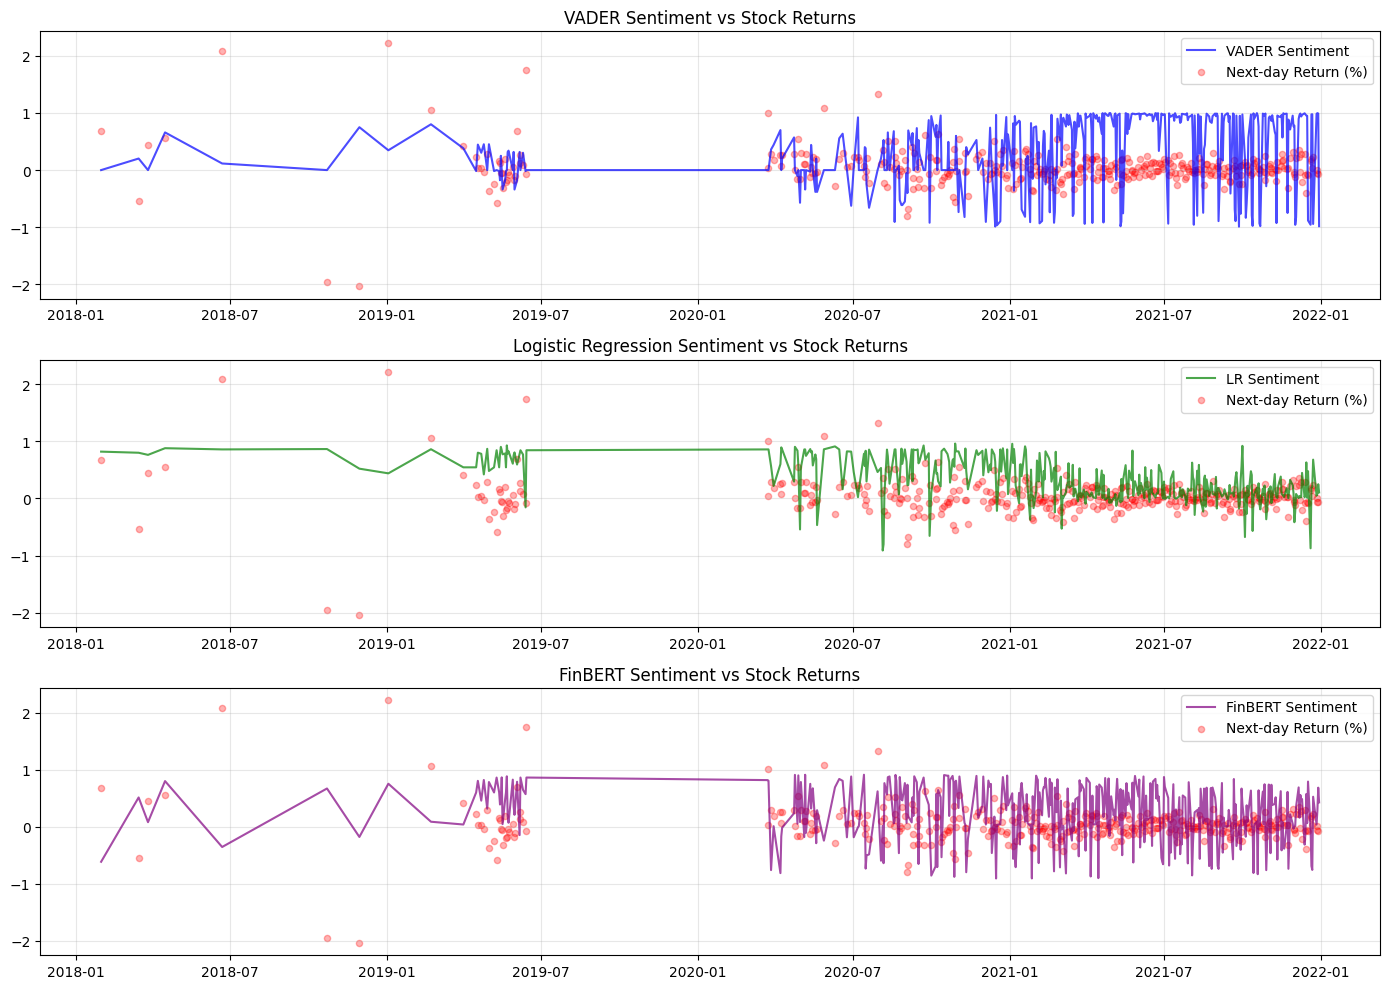

In [126]:
obj1=CorrelationAnalysis(data)
print(obj1.calculate_correlations().head())
obj1.generate_trading_signals()
obj1.visualize_sentiment_vs_price()
plt.show()

In [127]:
corr,x,y,date=obj1.my_correlations()
print(corr.head())

    method  correlation   p_value  n_samples
0    VADER    -0.001520  0.975882        398
1       LR     0.089613  0.074139        398
2  FINBERT     0.059462  0.236576        398


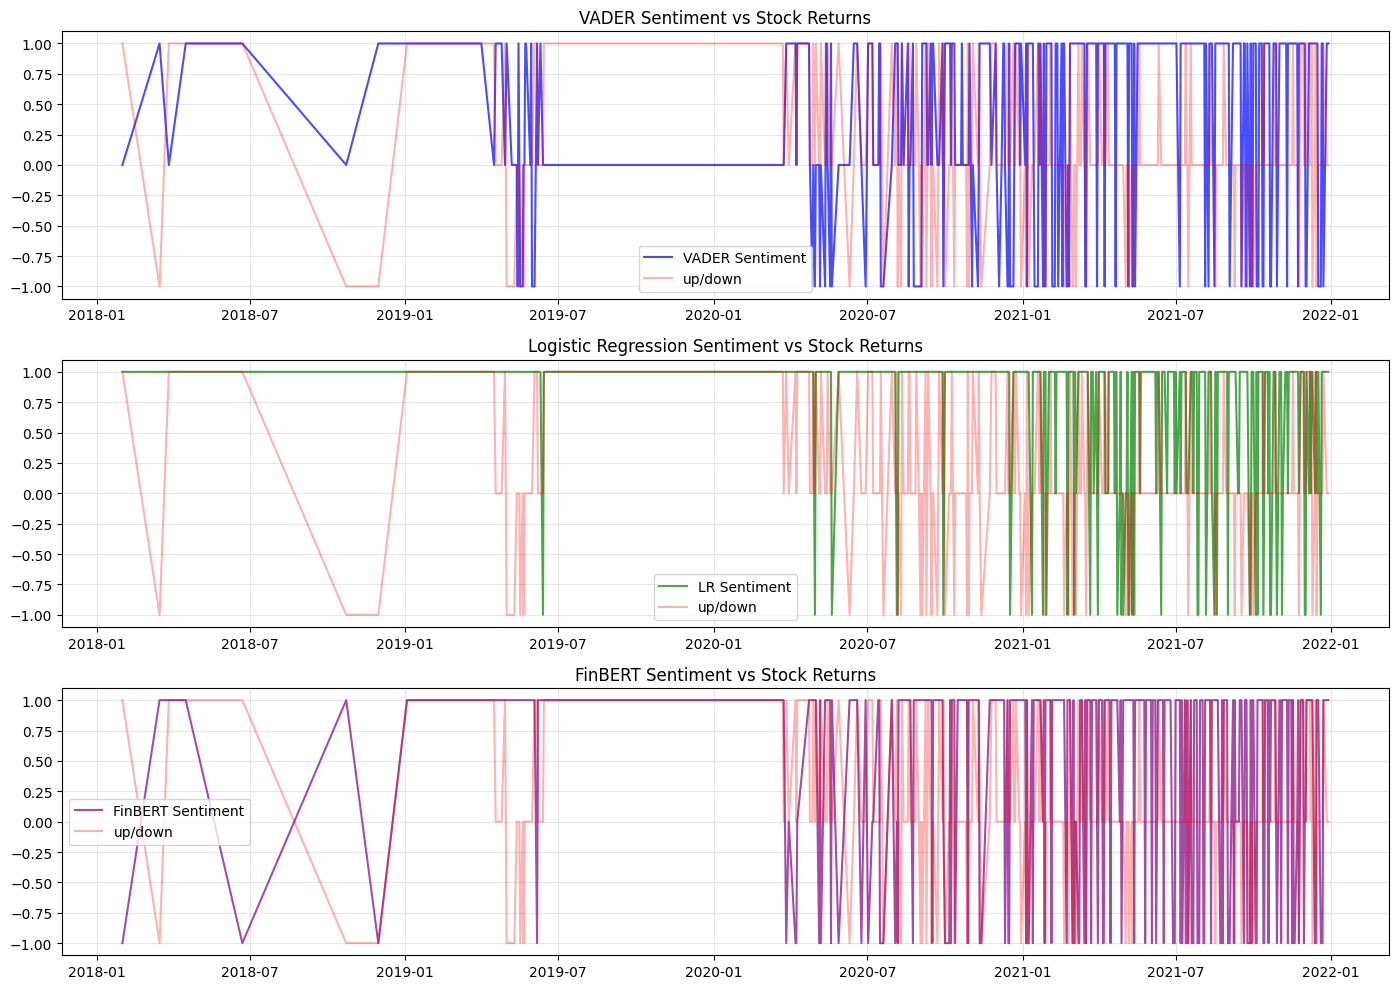

In [128]:
obj1.visualize2(x,y,date)
plt.show()